# Анализ факторов, влияющих на стоимость жилья: Построение и оптимизация модели линейной регрессии

## Описание проекта:

Цель данного проекта — исследовать зависимость стоимости домов от различных характеристик (например, площади, количества спален, наличия кондиционера и т.д.) и построить надежную модель линейной регрессии для прогнозирования цен. Проект включает несколько этапов анализа данных, начиная с базовой визуализации и заканчивая проверкой статистических предположений и оптимизацией модели.

**Версии библиотек:**

- pandas 2.1.4
- numpy 1.26.4
- statsmodels 0.14.0
- seaborn 0.13.2
- matplotlib 3.8.0
- scikit-learn 1.2.2

Импорт библиотек

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import statsmodels as sm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

import random

RANDOM_STATE = 42

In [ ]:
def metrics_report(y_true, y_pred):
    print(f'R2 score: {r2_score(y_true, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')


Линейная регрессия позволяет проверить гипотезу об отличии коэффициента от нуля.

Пусть имеется набор данных о стоимости какого-то товара. В таблице две колонки: значение некоторой характеристики товара и его стоимость в рублях. Построим линейную регрессию из sklearn и statsmodels.

In [ ]:
# Загрузим данные из файла task0.csv и выведим первые 5 строк на экран
df = pd.read_csv('task0.csv')
df.head(5)

,Unnamed: 0,feature,cost
0,0,18.189092,12169
1,1,4.862900,19431
2,2,5.874894,10816
3,3,99.297459,7779
4,4,59.958159,19862


Визуализация данных

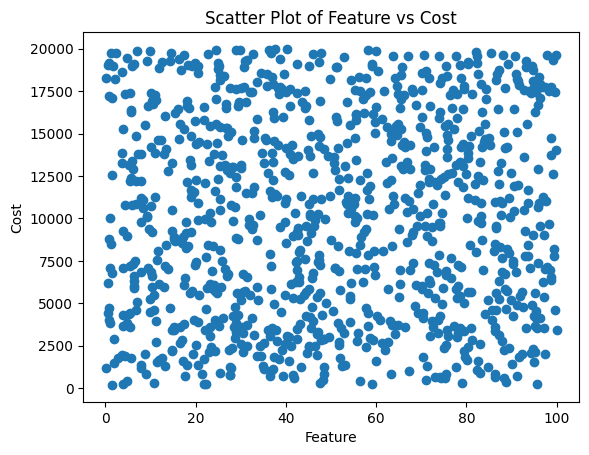

In [ ]:
# Построим scatterplot
plt.scatter(
    x=df['feature'],  # Указываем данные для оси X
    y=df['cost']      # Указываем данные для оси Y
)
plt.xlabel('Feature')  # Подпись оси X
plt.ylabel('Cost')     # Подпись оси Y
plt.title('Scatter Plot of Feature vs Cost')  # Заголовок графика
plt.show()  # Отображение графика


Построение модели линейной регрессии sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

# Создание модели линейной регрессии
lin_reg = LinearRegression()

# Разделение данных на признаки и целевую переменную
X = df[['feature']]  # Признак
y = df['cost']       # Целевая переменная

# Обучение модели на всем датафрейме
lin_reg.fit(X, y)

# Вывод коэффициентов
print("Intercept:", lin_reg.intercept_)
print("Coefficient:", lin_reg.coef_[0])


Intercept: 9765.480136229104
Coefficient: 6.0658441753499694


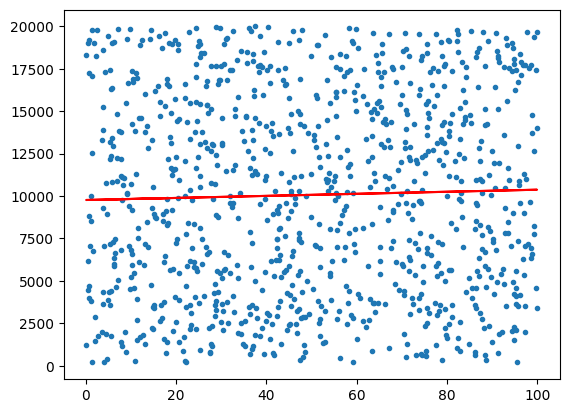

In [ ]:
# График предсказаний регрессии
plt.scatter(x=df['feature'], y=df['cost'], marker='.')
plt.plot(df['feature'], lin_reg.predict(df[['feature']]), color='r')
plt.show()

Построение модели линейной регрессии statsmodels

Теперь построим регрессию из statsmodels. Но прежде чем это сделать, необходимо добавить в выборку константу с помощью функции sm.add_constant().
Это необходимое техническое действие, без которого предсказания модели будут некорректными

In [ ]:
# Добавление константы к выборке
X_sm = sm.add_constant(X)

In [ ]:
# Построение и обучение модели
ols_model = sm.OLS(y, X_sm)
ols_res = ols_model.fit()

# Вывод результатов обучения (summary)
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8924
Date:                Fri, 21 Feb 2025   Prob (F-statistic):              0.345
Time:                        18:19:19   Log-Likelihood:                -10085.
No. Observations:                1000   AIC:                         2.017e+04
Df Residuals:                     998   BIC:                         2.018e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9765.4801    370.682     26.345      0.0


Проверим предположение о необходимости репрезентативности выборки. Например, ограничим данные и сравним качество прогноза на полной и ограниченной выборках.

Пусть имеется набор данных о продажах домов. Рассмотрим две выборки, обучим на них модель линейной регрессии и сравним результаты. Первая выборка должна включать в себя только данные о домах, в которых не более 2 спальных комнат. Вторая выборка будет включать в себя все типы домов. Построим регрессию из statsmodels и выведем значения коэффициентов детерминации в обоих случаях.

In [ ]:
data = pd.read_csv('house_prices.csv')
data.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [ ]:
# Список категориальных переменных
var_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Список количественных переменных
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']


In [ ]:
# Первая выборка: дома с двумя или менее спальнями
X1 = data[data['bedrooms'] <= 2]
y1 = X1['price']

# Вторая выборка: все дома
X2 = data
y2 = X2['price']


In [ ]:
# Замена 'yes'/'no' на 1/0 для бинарных признаков
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for var in binary_vars:
    data[var] = data[var].map({'yes': 1, 'no': 0})

In [ ]:
# Кодировка категориальных признаков для первой выборки
encoder1 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
furnished_enc_1 = pd.DataFrame(
    encoder1.fit_transform(X1[['furnishingstatus']]),
    columns=encoder1.categories_
)

# Кодировка категориальных признаков для второй выборки
encoder2 = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
furnished_enc_2 = pd.DataFrame(
    encoder2.fit_transform(X2[['furnishingstatus']]),
    columns=encoder2.categories_
)

In [ ]:
# Масштабирование количественных признаков для первой выборки
scaler1 = StandardScaler()
X1_numeric = pd.DataFrame(
    scaler1.fit_transform(X1[var_numeric]),
    columns=var_numeric
)

# Масштабирование количественных признаков для второй выборки
scaler2 = StandardScaler()
X2_numeric = pd.DataFrame(
    scaler2.fit_transform(X2[var_numeric]),
    columns=var_numeric
)

In [ ]:
# Соберите все в один датафрейм
X1_enc = X1_numeric.join([furnished_enc_1, X1[var_categorical].reset_index(drop=True)]).drop('furnishingstatus', axis=1)
X1_enc.shape

(138, 14)

In [ ]:
# Объединение всех признаков в один датафрейм
X2_enc = X2_numeric.join([furnished_enc_2, X2[binary_vars].reset_index(drop=True)])

In [ ]:
# Переименование колонок для X1_enc
furnished_enc_1.columns = ['furnishingstatus_furnished', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']

# Удаление лишней колонки 'unfurnished'
furnished_enc_1 = furnished_enc_1.drop(columns=['furnishingstatus_unfurnished'])

# Объединение всех признаков в X1_enc
X1_enc = X1_numeric.join([furnished_enc_1, X1[binary_vars].reset_index(drop=True)])

In [ ]:
# Переименование колонок для X2_enc
furnished_enc_2.columns = ['furnishingstatus_furnished', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']

# Удаление лишней колонки 'unfurnished'
furnished_enc_2 = furnished_enc_2.drop(columns=['furnishingstatus_unfurnished'])

# Объединение всех признаков в X2_enc
X2_enc = X2_numeric.join([furnished_enc_2, X2[binary_vars].reset_index(drop=True)])

In [ ]:
# Добавление константы к X1_enc
X1_enc = sm.add_constant(X1_enc)

# Добавление константы к X2_enc
X2_enc = sm.add_constant(X2_enc)

In [ ]:
# Сброс индексов в y1 и y2
y1 = y1.reset_index(drop=True)
y2 = y2.reset_index(drop=True)

In [ ]:
# Создание и обучение модели для первой выборки
ols1 = sm.OLS(y1, X1_enc)  # Создание модели
ols1_res = ols1.fit()       # Обучение модели
print(ols1_res.summary())   # Вывод информации о модели

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     17.69
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           1.83e-22
Time:                        19:10:26   Log-Likelihood:                -2030.0
No. Observations:                 138   AIC:                             4088.
Df Residuals:                     124   BIC:                             4129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [ ]:
print(X1_enc.dtypes)
print(X2_enc.dtypes)

const                              float64
area                               float64
bedrooms                           float64
bathrooms                          float64
stories                            float64
parking                            float64
furnishingstatus_furnished         float64
furnishingstatus_semi-furnished    float64
mainroad                             int64
guestroom                            int64
basement                             int64
hotwaterheating                      int64
airconditioning                      int64
prefarea                             int64
dtype: object
const                              float64
area                               float64
bedrooms                           float64
bathrooms                          float64
stories                            float64
parking                            float64
furnishingstatus_furnished         float64
furnishingstatus_semi-furnished    float64
mainroad                             int

In [ ]:
# Список бинарных признаков
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Преобразуем бинарные признаки в числовой тип
for var in binary_vars:
    X1_enc[var] = X1_enc[var].astype(int)  # Преобразуем в int

In [ ]:
# Замена 'yes' на 1 и 'no' на 0
for var in binary_vars:
    X1_enc[var] = X1_enc[var].map({'yes': 1, 'no': 0})

In [ ]:
for var in binary_vars:
    X1_enc[var] = X1_enc[var].astype(int)

In [ ]:
# Создание и обучение модели для второй выборки
ols2 = sm.OLS(y2, X2_enc)  # Создание модели
ols2_res = ols2.fit()       # Обучение модели
print(ols2_res.summary())   # Вывод информации о модели

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Fri, 21 Feb 2025   Prob (F-statistic):          9.07e-123
Time:                        19:12:46   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [ ]:
# Предсказание для первой модели (ols1) на данных X2_enc
y_pred_ols1 = ols1.predict(X2_enc)

# Вывод метрик для первой модели
print("Метрики для первой модели (ols1) на полном наборе данных:")
metrics_report(y2, y_pred_ols1)

In [ ]:
print(X1_enc.columns)
print(X2_enc.columns)

Index(['const', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking',
       'furnishingstatus_furnished', 'furnishingstatus_semi-furnished',
       'mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')
Index(['const', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking',
       'furnishingstatus_furnished', 'furnishingstatus_semi-furnished',
       'mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea'],
      dtype='object')


In [ ]:
# Добавление недостающих столбцов в X2_enc
for col in X1_enc.columns:
    if col not in X2_enc.columns:
        X2_enc[col] = 0

# Убедимся, что столбцы в X2_enc соответствуют X1_enc
X2_enc = X2_enc[X1_enc.columns]

In [ ]:
print(X1_enc.shape)  # Должно быть (138, 14)
print(X2_enc.shape)  # Должно быть (545, 14)

(138, 14)
(545, 14)


In [ ]:
print(X1_enc.dtypes)
print(X2_enc.dtypes)

const                              float64
area                               float64
bedrooms                           float64
bathrooms                          float64
stories                            float64
parking                            float64
furnishingstatus_furnished         float64
furnishingstatus_semi-furnished    float64
mainroad                             int64
guestroom                            int64
basement                             int64
hotwaterheating                      int64
airconditioning                      int64
prefarea                             int64
dtype: object
const                              float64
area                               float64
bedrooms                           float64
bathrooms                          float64
stories                            float64
parking                            float64
furnishingstatus_furnished         float64
furnishingstatus_semi-furnished    float64
mainroad                             int

In [ ]:
if 'const' not in X1_enc.columns:
    X1_enc = sm.add_constant(X1_enc)

if 'const' not in X2_enc.columns:
    X2_enc = sm.add_constant(X2_enc)

In [ ]:
# Предсказание для первой модели (ols1) на данных X2_enc
y_pred_ols1 = ols1.predict(X2_enc)

# Вывод метрик для первой модели
print("Метрики для первой модели (ols1) на полном наборе данных:")
metrics_report(y2, y_pred_ols1)

# Предсказание для второй модели (ols2) на данных X2_enc
y_pred_ols2 = ols2.predict(X2_enc)

# Вывод метрик для второй модели
print("Метрики для второй модели (ols2) на полном наборе данных:")
metrics_report(y2, y_pred_ols2)

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Загрузка данных
data = pd.read_csv('house_prices.csv')

In [ ]:
# Ограниченная выборка (дома с не более чем 2 спальнями)
X1 = data[data['bedrooms'] <= 2]
y1 = X1['price']

# Полная выборка (все дома)
X2 = data
y2 = X2['price']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Список бинарных признаков
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Замена 'yes'/'no' на 1/0 для бинарных признаков
for var in binary_vars:
    X1[var] = X1[var].map({'yes': 1, 'no': 0})
    X2[var] = X2[var].map({'yes': 1, 'no': 0})

# Кодирование признака 'furnishingstatus' с помощью OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
furnishing_encoded_1 = encoder.fit_transform(X1[['furnishingstatus']])
furnishing_encoded_2 = encoder.transform(X2[['furnishingstatus']])

# Преобразуем закодированные признаки в DataFrame
furnishing_encoded_1 = pd.DataFrame(furnishing_encoded_1, columns=encoder.get_feature_names_out(['furnishingstatus']))
furnishing_encoded_2 = pd.DataFrame(furnishing_encoded_2, columns=encoder.get_feature_names_out(['furnishingstatus']))

# Масштабирование количественных признаков
scaler = StandardScaler()
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

X1_numeric = pd.DataFrame(scaler.fit_transform(X1[numeric_vars]), columns=numeric_vars)
X2_numeric = pd.DataFrame(scaler.transform(X2[numeric_vars]), columns=numeric_vars)

# Объединение всех признаков
X1_enc = pd.concat([X1_numeric, furnishing_encoded_1, X1[binary_vars].reset_index(drop=True)], axis=1)
X2_enc = pd.concat([X2_numeric, furnishing_encoded_2, X2[binary_vars].reset_index(drop=True)], axis=1)

# Добавление константы
X1_enc = sm.add_constant(X1_enc)
X2_enc = sm.add_constant(X2_enc)

In [ ]:
# Модель для ограниченной выборки
ols1 = sm.OLS(y1, X1_enc).fit()

# Модель для полной выборки
ols2 = sm.OLS(y2, X2_enc).fit()

Еще одно предположение, выполнение которого сильно влияет на результат работы линейной регрессии, - это предположение о строгой экзогенности. Суть заключается в следующем. Предположим, было составлено уравнение регрессии, в котором целевой признак `'y'` определяется признаком `'x'` и некоторой константой. Предположим также, что существует некоторый фактор `'t'`, который влияет и на `'x'`, и на `'y'`, однако в уравнении не присутствует. Это может быть какой-то невидимый нам, неявный фактор. Получается, что наше уравнение является неполным, не описывает картину в целом.

In [ ]:
# Создание нормально распределенного шума
rng = np.random.RandomState(RANDOM_STATE)
mu, sigma = 0, 0.1
eps = rng.normal(mu, sigma, size=1000)

In [ ]:
c_train = 0
c_test = 0.1

In [ ]:
# Создание набора данных
t = np.linspace(0, 1, 1000)

y = np.log(1 + t)
x = t + eps

df = pd.DataFrame({'t' : t, 'x' : x, 'y' : y})
df.head()

,t,x,y
0,0.000000,0.049671,0.000000
1,0.001001,-0.012825,0.001001
2,0.002002,0.066771,0.002000
3,0.003003,0.155306,0.002999
4,0.004004,-0.019411,0.003996


In [ ]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[['x', 't']], df['y'], test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

X_train['x'] += c_train
X_test['x'] += c_test

In [ ]:
# Добавление константы к данным
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [ ]:
# Модель 1: Регрессия y на x
X_train_x = X_train[['const', 'x']]  # Используем только 'x'
X_test_x = X_test[['const', 'x']]

model_x = sm.OLS(y_train, X_train_x).fit()
y_pred_x = model_x.predict(X_test_x)

# Модель 2: Регрессия y на t
X_train_t = X_train[['const', 't']]  # Используем только 't'
X_test_t = X_test[['const', 't']]

model_t = sm.OLS(y_train, X_train_t).fit()
y_pred_t = model_t.predict(X_test_t)

In [ ]:
from sklearn.metrics import r2_score

# R² для модели 1 (y на x)
r2_x = r2_score(y_test, y_pred_x)

# R² для модели 2 (y на t)
r2_t = r2_score(y_test, y_pred_t)

# Округление до 3 знаков
r2_x = round(r2_x, 3)
r2_t = round(r2_t, 3)

print(f"R² для модели y на x: {r2_x}")
print(f"R² для модели y на t: {r2_t}")

R² для модели y на x: 0.786
R² для модели y на t: 0.992


Отсюда можно сделать вывод о том, что для корректной работы модели важно правильно выбрать признаки.

Вернемся к данным о продаже домов. Построим матрицу корреляций числовых признаков для тренировочной выборки. Закодируем категориальные и масштабируем количественные. После этого построим регрессию из statsmodels и, проанализировав ее выдачу, определим признаки, не являющиеся полезными для построения модели.

In [ ]:
data = pd.read_csv('house_prices.csv')
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
# Список категориальных переменных
var_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Список количественных переменных
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [ ]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop(columns=['price'])
y = data['price']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# Построение матрицы корреляций для числовых признаков
corr_matrix = X_train[var_numeric].corr()

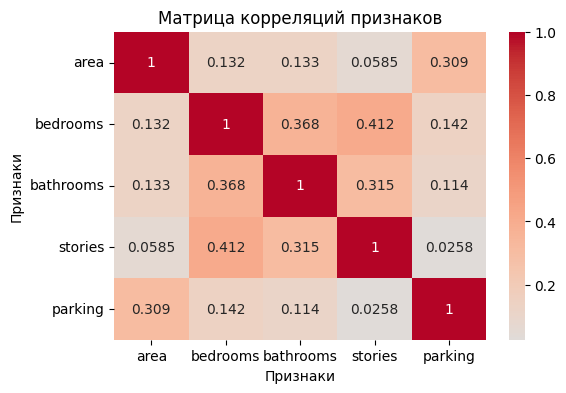

In [ ]:
# Построение тепловой карты
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, fmt='.3g', cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Список бинарных признаков
binary_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Замена 'yes'/'no' на 1/0 для бинарных признаков
for var in binary_vars:
    X_train[var] = X_train[var].map({'yes': 1, 'no': 0})
    X_test[var] = X_test[var].map({'yes': 1, 'no': 0})

# Кодирование признака 'furnishingstatus' с помощью OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
furnished_enc_train = encoder.fit_transform(X_train[['furnishingstatus']])
furnished_enc_test = encoder.transform(X_test[['furnishingstatus']])

# Преобразуем закодированные признаки в DataFrame
furnished_enc_train = pd.DataFrame(furnished_enc_train, columns=encoder.get_feature_names_out(['furnishingstatus']))
furnished_enc_test = pd.DataFrame(furnished_enc_test, columns=encoder.get_feature_names_out(['furnishingstatus']))

In [ ]:
# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train[var_numeric]), columns=var_numeric)
X_test_numeric = pd.DataFrame(scaler.transform(X_test[var_numeric]), columns=var_numeric)

In [ ]:
# Объединение всех признаков
X_train_processed = pd.concat([X_train_numeric, furnished_enc_train, X_train[binary_vars].reset_index(drop=True)], axis=1)
X_test_processed = pd.concat([X_test_numeric, furnished_enc_test, X_test[binary_vars].reset_index(drop=True)], axis=1)

In [ ]:
# Сброс индексов в целевой переменной
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
import statsmodels.api as sm

# Добавление константы к данным
X_train_sm = sm.add_constant(X_train_processed)
X_test_sm = sm.add_constant(X_test_processed)

In [ ]:
# Построение модели
model = sm.OLS(y_train, X_train_sm).fit()

# Вывод результатов модели
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     46.60
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           3.00e-65
Time:                        05:57:08   Log-Likelihood:                -4965.2
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     313   BIC:                         1.001e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [ ]:
# Анализ p-значений
p_values = model.pvalues

# Признаки с p-value > 0.05 (не являются полезными)
useless_features = p_values[p_values > 0.05]

# Вывод бесполезных признаков и их p-значений
for feature, p_value in useless_features.items():
    print(f"{feature}: {p_value:.3f}")

bedrooms: 0.224
furnishingstatus_semi-furnished: 0.261


In [ ]:
# Матрица корреляций для числовых признаков
corr_matrix = X_train[var_numeric].corr()

# Коэффициент корреляции Пирсона между 'bedrooms' и 'stories'
corr_coef = corr_matrix.loc['bedrooms', 'stories']
print(f"Коэффициент корреляции между 'bedrooms' и 'stories': {corr_coef:.3f}")

Коэффициент корреляции между 'bedrooms' и 'stories': 0.412


Проверим важность признаков. Для этого построим регрессию только на площади квартиры.

In [ ]:
# Добавление константы и выбор только площади
X_train_area = sm.add_constant(X_train_processed[['area']])

# Построение модели
model_area = sm.OLS(y_train, X_train_area).fit()

# Вывод R²
r2_area = model_area.rsquared
print(f"R² для регрессии только на площади: {r2_area:.3f}")

R² для регрессии только на площади: 0.284


Теперь построим регрессию на всех признаках, кроме неважных

In [ ]:
# Удаление неважного признака (bedrooms)
X_train_filtered = X_train_processed.drop(columns=['bedrooms'])

# Построение модели
model_filtered = sm.OLS(y_train, X_train_filtered).fit()

# Вывод R²
r2_filtered = model_filtered.rsquared
print(f"R² для регрессии на всех признаках, кроме неважных: {r2_filtered:.3f}")

R² для регрессии на всех признаках, кроме неважных: 0.911


Узнаем каково примерное изменение стоимости дома при увеличении количества этажей на два (разумеется, при прочих равных)? Теория предписывает анализ коэффициента линейной регрессии.

In [ ]:
# Загрузка данных
data = pd.read_csv('house_prices.csv')

In [ ]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
# Создание нового датафрейма с увеличенным количеством этажей на 2
df = data.copy()
df['stories'] += 2
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,5,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,6,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,4,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,4,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,4,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
# Список категориальных переменных
var_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Список количественных переменных
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', sparse_output=False)
data_cat_encoded = encoder.fit_transform(data[var_categorical])
df_cat_encoded = encoder.transform(df[var_categorical])

# Преобразуем закодированные признаки в DataFrame
cat_encoded_columns = encoder.get_feature_names_out(var_categorical)
data_cat_encoded = pd.DataFrame(data_cat_encoded, columns=cat_encoded_columns)
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=cat_encoded_columns)

# Масштабирование количественных признаков
scaler = StandardScaler()
data_num_scaled = scaler.fit_transform(data[var_numeric])
df_num_scaled = scaler.transform(df[var_numeric])

# Преобразуем масштабированные признаки в DataFrame
data_num_scaled = pd.DataFrame(data_num_scaled, columns=var_numeric)
df_num_scaled = pd.DataFrame(df_num_scaled, columns=var_numeric)

# Объединение закодированных и масштабированных признаков
data_processed = pd.concat([data_num_scaled, data_cat_encoded], axis=1)
df_processed = pd.concat([df_num_scaled, df_cat_encoded], axis=1)

# Добавление константы
data_sm = sm.add_constant(data_processed)
df_sm = sm.add_constant(df_processed)

In [ ]:
# Построение модели на исходных данных
ols_model = sm.OLS(data['price'], data_sm).fit()

# Вывод коэффициента для признака 'stories'
stories_coef = ols_model.params['stories']
print(f"Коэффициент для признака 'stories': {stories_coef:.3f}")

Коэффициент для признака 'stories': 390748.266


In [ ]:
# Предсказания на исходных данных
y_pred_original = ols_model.predict(data_sm)

# Предсказания на данных с увеличенным количеством этажей
y_pred_modified = ols_model.predict(df_sm)

# Вычисление изменения стоимости
price_change = y_pred_modified - y_pred_original
average_price_change = price_change.mean()
print(f"Среднее изменение стоимости при увеличении этажей на 2: {average_price_change:.3f}")

Среднее изменение стоимости при увеличении этажей на 2: 901696.006


Теперь займемся проверкой допущений. Для начала проверим отсутствие мультиколлинеарности. Это можно сделать с помощью VIF (Variance Inflation Factor). Если он будет больше 4 (договорное значение, аналогичное p-value), то эта переменная коррелирует с какой-то из присутствующих, и ее нужно убрать.

In [ ]:
# random_state=RANDOM_STATE, перемешивание включено, размер тестовой выборки 0.4
X, y = # ваш код здесь
X_train, X_test, y_train, y_test = # ваш код здесь

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Определение RANDOM_STATE
RANDOM_STATE = 42

# Загрузка данных
data = pd.read_csv('house_prices.csv')

# Разделение на признаки (X) и целевую переменную (y)
X = data.drop(columns=['price'])
y = data['price']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# Список категориальных переменных
var_categorical = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Список количественных переменных
var_numeric = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train[var_categorical])
X_test_cat_encoded = encoder.transform(X_test[var_categorical])

# Преобразуем закодированные признаки в DataFrame
cat_encoded_columns = encoder.get_feature_names_out(var_categorical)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns=cat_encoded_columns)
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns=cat_encoded_columns)

# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[var_numeric])
X_test_num_scaled = scaler.transform(X_test[var_numeric])

# Преобразуем масштабированные признаки в DataFrame
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=var_numeric)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=var_numeric)

# Объединение закодированных и масштабированных признаков
X_train_enc = pd.concat([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_enc = pd.concat([X_test_num_scaled, X_test_cat_encoded], axis=1)

In [ ]:
# Добавление колонки и удаление незначимого признака

X_train_enc = X_train_enc.drop('bedrooms', axis=1)

X_train_enc['special_index'] = X_train_enc['stories'] * 2 + 0.5

In [ ]:
# Удаление незначимого признака 'bedrooms'
X_train_enc = X_train_enc.drop('bedrooms', axis=1)

# Добавление новой колонки 'special_index'
X_train_enc['special_index'] = X_train_enc['stories'] * 2 + 0.5

In [ ]:
# Вычислите VIF и найдите коррелирующие признаки
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_enc.columns

vif_data["VIF"] = # ваш код здесь
vif_data

In [ ]:
# Расчет VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_enc.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_enc.values, i) for i in range(X_train_enc.shape[1])]

print(vif_data)

                            feature         VIF
0                              area    1.330976
1                         bathrooms    1.184137
2                           stories  207.713172
3                           parking    1.172669
4                      mainroad_yes    1.177293
5                     guestroom_yes    1.297299
6                      basement_yes    1.368774
7               hotwaterheating_yes    1.076890
8               airconditioning_yes    1.305283
9                      prefarea_yes    1.140299
10  furnishingstatus_semi-furnished    1.575707
11     furnishingstatus_unfurnished    1.674554
12                    special_index  220.776801


In [ ]:
# Сброс индексов в y_train
y_train = y_train.reset_index(drop=True)

# Сброс индексов в X_train_enc_filtered
X_train_enc_filtered = X_train_enc_filtered.reset_index(drop=True)

In [ ]:
# Регрессия с одним из коррелирующих признаков (удаляем 'special_index')
X_train_enc_filtered = X_train_enc.drop('special_index', axis=1)
X_train_enc_filtered = sm.add_constant(X_train_enc_filtered)

model_filtered = sm.OLS(y_train, X_train_enc_filtered).fit()
print(model_filtered.summary())

# Регрессия с обоими коррелирующими признаками
X_train_enc_all = sm.add_constant(X_train_enc)
model_all = sm.OLS(y_train, X_train_enc_all).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     50.29
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           8.54e-66
Time:                        08:45:31   Log-Likelihood:                -4966.0
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     314   BIC:                         1.001e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

С помощью теста Уайта проверим отсутствие гетероскедастичности, то есть равенство дисперсий ошибок.

О тесте Уайта. В качестве нулевой гипотезы примем равенство дисперсий ошибок. Альтернатива, соответственно, будет за нарушение этого равенства. Если мы будем вынуждены отвергнуть нулевую гипотезу ($p-value < 0.05$), то можно будет сделать вывод о присутствии гетероскедастичности в наших данных.

Суть теста в следующем. Часто гетероскедастичность модели вызвана зависимостью (возможно, довольно сложной) дисперсий ошибок от признаков. На основе этого факта можно провести тест без каких-либо предположений о структуре гетероскедастичности. Сначала к исходной модели применяется обычный метод наименьших квадратов и находятся остатки регрессии $e_t$. Затем осуществляется регрессия квадратов этих остатков $e_t^2$ на все признаки, их квадраты, попарные произведения и константу. Тогда при гипотезе $H_0$ величина $NR^2$ асимптотически имеет распределение $\chi^2(N-1)$, где $R^2$ — коэффициент детерминации, а $N$ — число регрессоров второй регрессии. Плюс данного теста — его универсальность. Минусы : 1) если гипотеза $H_0$ отвергается, то никаких указаний на функциональную форму гетероскедастичности мы не получаем; 2) поиск вида регрессии вслепую (начинаем приближать простыми полиномами второй степени без какой бы то ни было причины на это)

In [ ]:
print(X_train_enc.columns)

Index(['area', 'bathrooms', 'stories', 'parking', 'mainroad_yes',
       'guestroom_yes', 'basement_yes', 'hotwaterheating_yes',
       'airconditioning_yes', 'prefarea_yes',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished',
       'special_index'],
      dtype='object')


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import matplotlib.pyplot as plt

# Удаление незначимых признаков
X_train_enc_filtered = X_train_enc.drop(['special_index'], axis=1)

# Добавление константы
X_train_enc_filtered = sm.add_constant(X_train_enc_filtered)

# Построение модели
ols_model = sm.OLS(y_train, X_train_enc_filtered).fit()

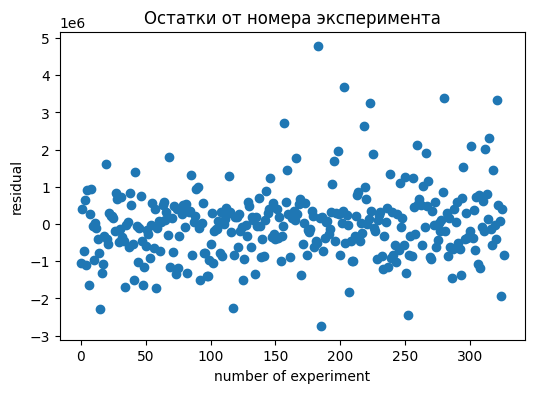

In [ ]:
# График остатков от номера эксперимента
plt.figure(figsize=(6, 4))
plt.xlabel('number of experiment')
plt.ylabel('residual')
plt.scatter(x=list(range(ols_model.resid.shape[0])), y=ols_model.resid)
plt.title('Остатки от номера эксперимента')
plt.show()

In [ ]:
# Проведение теста Уайта
white_test = het_white(ols_model.resid, ols_model.model.exog)

# Вывод результатов теста
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, white_test)))

# p-value теста Уайта
p_value_white_test = white_test[1]
print(f"p-value теста Уайта: {p_value_white_test:.3f}")

{'Test Statistic': 144.51116561282186, 'Test Statistic p-value': 1.3480696353116847e-05, 'F-Statistic': 2.4350631409953776, 'F-Test p-value': 8.34157872544433e-08}
p-value теста Уайта: 0.000


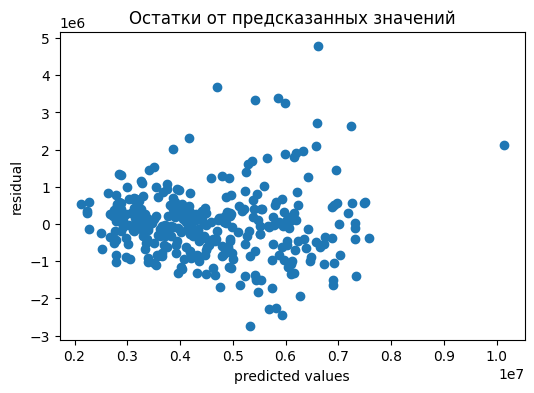

In [ ]:
# График остатков от предсказанных значений
plt.figure(figsize=(6, 4))
plt.xlabel('predicted values')
plt.ylabel('residual')
plt.scatter(x=ols_model.fittedvalues, y=ols_model.resid)
plt.title('Остатки от предсказанных значений')
plt.show()

В результате выполнения проекта будет построена модель линейной регрессии, которая позволяет прогнозировать стоимость дома на основе его характеристик. Также будут выявлены наиболее важные факторы, влияющие на цену, и проверены основные предположения линейной регрессии.

Этот проект может быть полезен для риелторских компаний, банков или частных лиц, заинтересованных в точном прогнозировании стоимости недвижимости.